In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

#from tensorflow import set_random_seed 
from tensorflow.random import set_seed 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot

# Функции 

In [2]:
def invboxcox(y,lmbda):# обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        if np.std(data[i-N:i]) == 0:
            std_list.append(1)
        else:
            std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [3]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=0, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    #print(np.isnan(np.sum(x_cv_scaled))) # есть nan
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    
    #print(np.isnan(np.sum(y_cv)), np.isnan(np.sum(est)))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    r2 = r2_score(y_cv, est)
    
    return rmse, mape, r2 , est

# Загрузка данных


In [4]:
# загрузка dataset
db = pd.read_csv('SalesX.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False) #1,045,311 

In [55]:
df2 = db
df2.info()
df2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1045311 entries, 2015-08-30 13:17:00 to 2016-06-11 11:52:00
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ID        1045311 non-null  object 
 1   Category  1045311 non-null  object 
 2   Brand     1045311 non-null  object 
 3   GMV       1045311 non-null  float64
 4   MRP       1045311 non-null  int64  
 5   Units     1045311 non-null  int64  
 6   SLA       1045311 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 63.8+ MB


,ID,Category,Brand,GMV,MRP,Units,SLA
Date,,,,,,,
2015-08-30 13:17:00,ACCE7U2GBCJKQZZV,CameraAccessory,Lens,285.0,395,1,16
2015-09-14 16:06:00,AUDEAFDA5GGESPWX,EntertainmentSmall,AudioMP3Player,299.0,999,1,8
2015-09-15 13:06:00,ACCDH7MFZJGRWJCW,GamingHardware,GamePad,284.0,410,1,5
2015-09-22 11:26:00,VGLE7AUXCYJWGBRV,EntertainmentSmall,VideoGlasses,419.0,349,1,9
2015-09-22 17:17:00,REME69QDWFWZGUMB,EntertainmentSmall,RemoteControl,490.0,999,1,8
...,...,...,...,...,...,...,...
2016-05-28 22:27:00,HTHEEDSFSPX3CUHK,EntertainmentSmall,HomeTheatre,2149.0,5999,1,6
2016-05-30 17:51:00,ACCEACG4KY7EAFHR,EntertainmentSmall,LaptopSpeaker,348.0,999,1,4
2016-05-30 17:51:00,ACCE5FQEJWG7TCB4,GamingHardware,GamingAccessoryKit,199.0,599,1,1


Text(0, 0.5, 'usd')

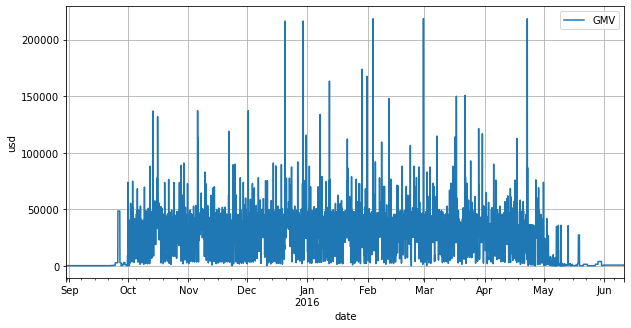

In [56]:
df = df2['GMV'].resample('h').max() #last() first() min() max() mean()
df = df.fillna(method='ffill')
df.plot(figsize=(10,5),label="GMV", grid = True)
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("usd")

In [57]:
df = df2[['GMV','MRP','SLA','Units']].resample('h').max()
df = df.fillna(method='ffill')

In [58]:
df = pd.DataFrame({'GMV': df.GMV/10,'MRP': df.MRP/10,
                   'SLA': df.SLA,'Units': df.Units
                   })
#df

count     6863.000000
mean      2516.652557
std       1979.410563
min         12.900000
25%        285.000000
50%       3049.000000
75%       3663.900000
max      21850.000000
Name: GMV, dtype: float64
V = 0.786525


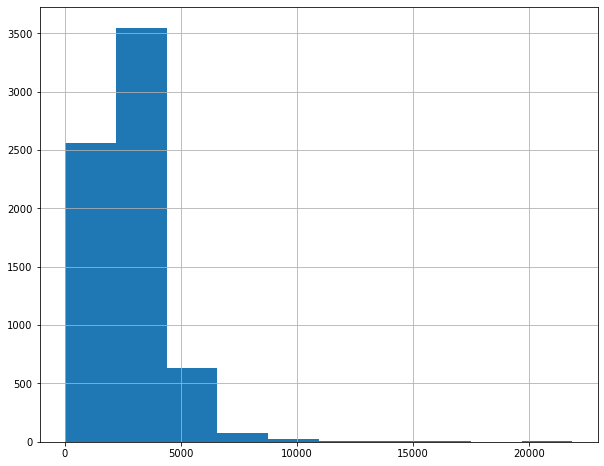

In [59]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df['GMV'].hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [60]:
j = 0
l = []
for i in range(0, 6863):
    if df.GMV[i] > 8000:
        df.replace(df.GMV[i], np.nan, inplace=True)
        df.fillna(method='ffill',inplace=True )
        j+=1
        l.append(i)

count    6863.000000
mean     2452.123386
std      1764.706038
min        12.900000
25%       285.000000
50%      3030.000000
75%      3650.000000
max      7899.900000
Name: GMV, dtype: float64
V = 0.719664


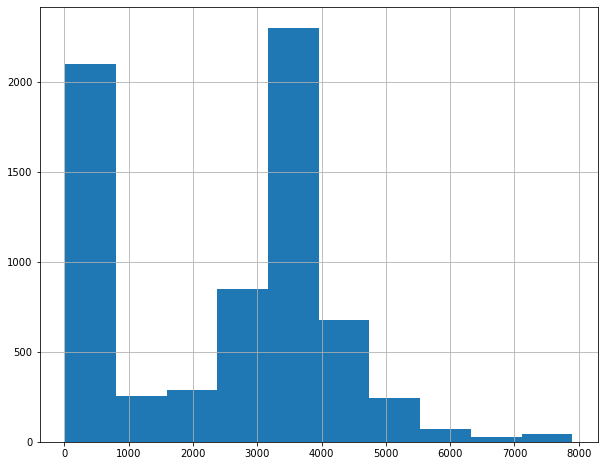

In [61]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df['GMV'].hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

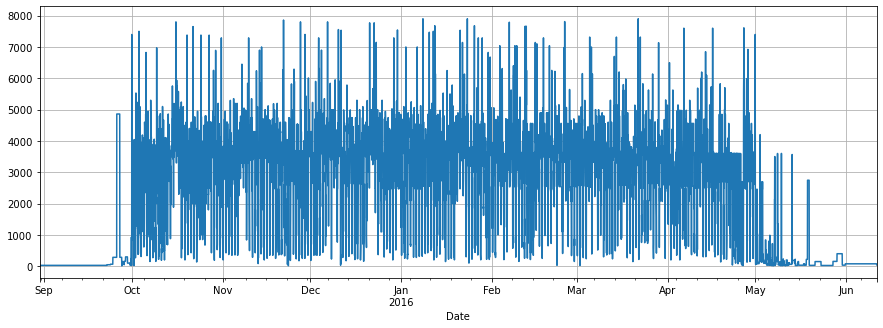

In [62]:
df['GMV'].plot(figsize=(15,5), grid = True)

Оптимальный параметр преобразования Бокса-Кокса: 0.521195
Критерий Дики-Фуллера: p=0.026532 < 0.05


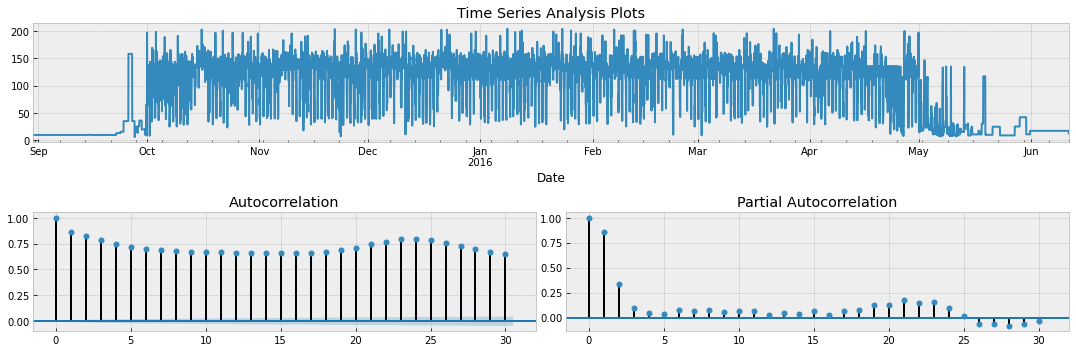

In [63]:
from statsmodels.iolib.table import SimpleTable
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(15, 5), style='bmh'): # Критерий Дики-Фуллера
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1],'< 0.05')

    return 

df['GMV_'] = df.GMV
df['GMV'], lmbda = scs.boxcox(df.GMV)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
tsplot(df.GMV, lags=30)
#df.drop(['GMV1'], axis=1, inplace=True)

In [64]:
# Convert Date column to datetime
df["Date"] = df.index.date

df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
#df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df['range_mg'] = df.mrp - df.gmv 
#df.drop(['units'], axis=1, inplace=True)

In [65]:
df.head()

,gmv,mrp,sla,units,gmv_,date,range_mg
Date,,,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,30.422079
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,30.422079
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,30.422079
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,30.422079
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,30.422079


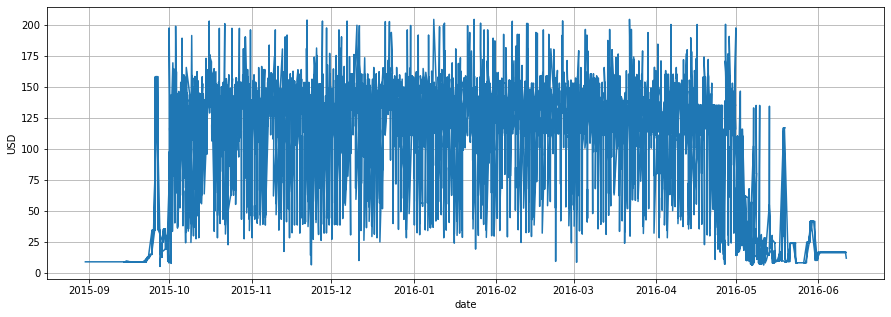

In [66]:
# Plot adjusted close over time
plt.figure(figsize=(15, 5))
plt.plot(df.gmv)
plt.xlabel("date")
plt.ylabel("USD")
plt.grid(True)

# Split into train, dev and test sets

In [67]:
# Get sizes of each of the datasets
test_size = 0.3                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 


num_cv, num_test = int(cv_size*len(df)), int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print('Количество:')
print("num_train = " + str(num_train),
      "\n num_cv = " + str(num_cv), 
      "\n num_test = " + str(num_test))

# Разделить на train, cv, and test
train = df[:num_train][['date', 'gmv', 'gmv_']]
cv = df[num_train:num_train+num_cv][['date', 'gmv', 'gmv_']]
train_cv = df[:num_train+num_cv][['date', 'gmv', 'gmv_']]
test = df[num_train+num_cv:][['date', 'gmv', 'gmv_']]
print('Размерность:')
print(" train = " + str(train.shape),
        "\n cv = " + str(cv.shape), "~ train_cv = " + str(train_cv.shape),
        "\n test = " + str(test.shape))

Количество:
num_train = 3433 
 num_cv = 1372 
 num_test = 2058
Размерность:
 train = (3433, 3) 
 cv = (1372, 3) ~ train_cv = (4805, 3) 
 test = (2058, 3)


In [68]:
# Преобразование набора данных в x_train и y_train
# Здесь мы масштабируем только обучающий набор данных, а не весь набор данных, чтобы предотвратить утечку информации

scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['gmv']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Разделить на x и y

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [99.95928573]
scaler.var_ = [2953.37763333]
x_train_scaled.shape = (3424, 9, 1)
y_train_scaled.shape = (3424, 1)


In [69]:
# Масштабировать набор данных cv
# Разделить на x и y

x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['gmv']).reshape(-1,1), N, num_train)

print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (1372, 9, 1)
y_cv.shape = (1372, 1)
len(mu_cv_list) = 1372
len(std_cv_list) = 1372


In [70]:
# Здесь мы масштабируем набор train_cv для окончательной модели

scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['gmv']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['gmv']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [107.75010528]
scaler_final.var_ = [2501.08342194]
x_test_scaled.shape = (2058, 9, 1)
y_test.shape = (2058, 1)
len(mu_test_list) = 2058
len(std_test_list) = 2058


# Create and fit the LSTM network

In [71]:
#### Input params ##################

# initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam' #  'nadam'    # lstm param. initial value before tuning.
epochs= 0                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
set_seed(model_seed)

# Create the LSTM network


model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

In [72]:
# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 9, 50)             10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 50)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Plot model and save to file
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\axmatov.ari\anaconda3\lib\site-packages\keras\utils\__init__.py)

# Predict проверочной выборки

In [73]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

# Calculate R2
from sklearn.metrics import r2_score
r2_bef_tuning = r2_score(y_cv, est)
print("R2 = %0.3f" % r2_bef_tuning)

est.shape = (1372, 1)
RMSE = 30.779
MAPE = 28.725%
R2 = -0.131


Text(0, 0.5, 'USD')

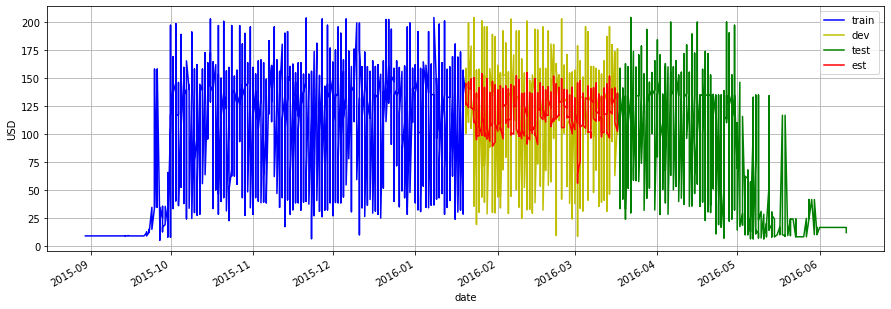

In [50]:
# Plot adjusted close over time
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='gmv', style='b-', grid=True)
ax = cv.plot(x='date', y='gmv', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='gmv', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Tuning N (no. of days to use as features)

In [49]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': [],'r2': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['gmv']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, r2, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    error_rate['r2'].append(r2)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

<ipython-input-49-c4d0ad964c11>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


<ipython-input-48-7357f5e2dd1c>:40: RuntimeWarning: invalid value encountered in true_divide
  x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])


NameError: name 'rmse' is not defined

In [51]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

NameError: name 'error_rate' is not defined

# Final model

In [74]:
N_opt = 4


# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['gmv']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, r2 , est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list)

# Calculate RMSE,MAPE,R2
print("RMSE on test set = {:.4}".format(rmse))
print("MAPE on test set = {:.4}%".format(mape))
print("R2 on test set = {:.4}".format(r2))

RMSE on test set = 26.87
MAPE on test set = 34.41%
R2 on test set = 0.7732


Text(0, 0.5, 'USD')

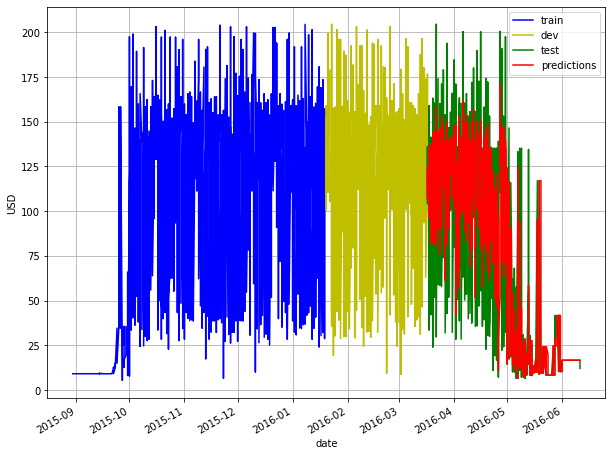

In [53]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='gmv', style='b-', grid=True)
ax = cv.plot(x='date', y='gmv', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='gmv', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")


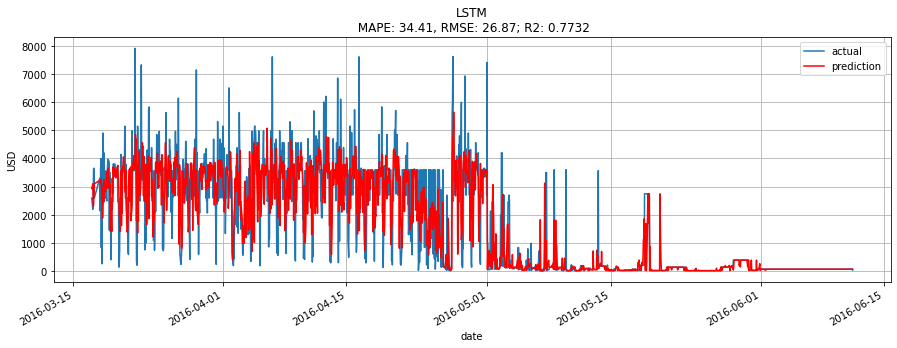

In [75]:
# График прогноза
est_df["est_"] = invboxcox(est_df.est, lmbda)

test.gmv_.plot(figsize=(15,5), label="actual")
est_df.est_.plot(figsize=(15,5), label="prediction", color = 'r')
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("USD")
#plt.xlim([1, 30])
plt.title("LSTM\n MAPE: {:.4}, RMSE: {:.4}; R2: {:.4}".format(
    get_mape(test.gmv, est_df.est),
    np.sqrt(mean_squared_error(test.gmv, est_df.est)),
    r2_score(test.gmv, est_df.est)))
plt.grid(True)

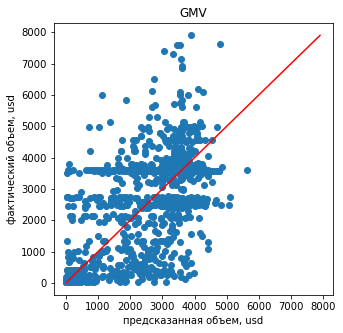

In [77]:
plt.figure(figsize=(5, 5))
plt.scatter(est_df.est_,test.gmv_)
plt.title("GMV")
plt.ylabel('фактический объем, usd')
plt.xlabel('предсказанная объем, usd')
plt.plot([test.gmv_.min(), test.gmv_.max()],[[test.gmv_.min()],[test.gmv_.max()]], color = 'red')

In [81]:
itog_model = pd.DataFrame({'LSTM': est_df.est_})
#Сохранение нового файла 
itog_model.to_csv('itog_model_LSTM.csv', sep=';', encoding='utf-8')

In [83]:
est

array([[121.09609914],
       [106.88495061],
       [106.90129793],
       ...,
       [ 16.653395  ],
       [ 16.653395  ],
       [ 16.653395  ]])

In [84]:
est_df.est

Date
2016-03-17 02:00:00    121.096099
2016-03-17 06:00:00    106.884951
2016-03-17 07:00:00    106.901298
2016-03-17 08:00:00    115.867459
2016-03-17 09:00:00    124.823493
                          ...    
2016-06-11 02:00:00     16.653395
2016-06-11 01:00:00     16.653395
2016-06-11 00:00:00     16.653395
2016-06-11 04:00:00     16.653395
2016-06-11 11:00:00     16.653395
Name: est, Length: 2058, dtype: float64